In [ ]:
# Load Package
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# Set Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# 1. Dataset Preparation

In [ ]:
# Hyperparameters
batch_size = 128
num_epochs = 150
learning_rate = 0.001
weight_decay = 2e-4

In [ ]:
# Data Transformations
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

In [ ]:
# Load Datasets
print("Loading CIFAR-10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 2. Network Architecture

In [ ]:
# 2.1 Intermediate Block
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers=3, kernel_size=3, stride=1, padding=1, use_batch_norm=True):
        super(IntermediateBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_conv_layers = num_conv_layers

        # Create multiple independent convolutional layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            conv_block = []
            conv_block.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))

            if use_batch_norm:
                conv_block.append(nn.BatchNorm2d(out_channels))

            conv_block.append(nn.ReLU(inplace=True))
            self.conv_layers.append(nn.Sequential(*conv_block))

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_conv_layers),
            nn.Softmax(dim=1)
        )

        # Residual connection handling
        self.use_residual = (in_channels == out_channels)

        if in_channels != out_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        identity = x

        # Compute average value of each channel
        avg_channels = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)

        # Compute weights for each convolutional layer
        weights = self.fc(avg_channels)  # Shape: [batch_size, num_conv_layers]

        # Apply each convolutional layer independently
        conv_outputs = []
        for i, conv_layer in enumerate(self.conv_layers):
            conv_out = conv_layer(x)
            conv_outputs.append(conv_out)

        # Weighted sum of convolutional outputs
        combined_output = 0
        for i, conv_out in enumerate(conv_outputs):
            # Extract weights for current convolutional layer and reshape for broadcasting
            layer_weights = weights[:, i].view(-1, 1, 1, 1)
            combined_output += layer_weights * conv_out

        # Add residual connection
        if self.use_residual:
            combined_output += identity
        elif hasattr(self, 'projection'):
            combined_output += self.projection(identity)

        return combined_output

In [ ]:
# 2.2 Output Block
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()

        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(in_channels, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Pass through fully connected layers
        logits = self.classifier(x)

        return logits

In [ ]:
# Complete Network Architecture
class CIFAR10Network(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10Network, self).__init__()

        # Network blocks
        # First block
        self.block1 = IntermediateBlock(3, 64, num_conv_layers=3, kernel_size=3, padding=1, use_batch_norm=True)

        # Second block
        self.block2 = IntermediateBlock(64, 128, num_conv_layers=4, kernel_size=3, padding=1, use_batch_norm=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third block
        self.block3 = IntermediateBlock(128, 256, num_conv_layers=6, kernel_size=3, padding=1, use_batch_norm=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth block
        self.block4 = IntermediateBlock(256, 512, num_conv_layers=6, kernel_size=3, padding=1, use_batch_norm=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fifth block
        self.block5 = IntermediateBlock(512, 512, num_conv_layers=6, kernel_size=3, padding=1, use_batch_norm=True)

        # Output block
        self.output_block = OutputBlock(512, num_classes)

        # Regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Block 1
        x = self.block1(x)
        x = self.dropout(x)

        # Block 2
        x = self.block2(x)
        x = self.pool1(x)
        x = self.dropout(x)

        # Block 3
        x = self.block3(x)
        x = self.pool2(x)
        x = self.dropout(x)

        # Block 4
        x = self.block4(x)
        x = self.pool3(x)
        x = self.dropout(x)

        # Block 5
        x = self.block5(x)

        # Output Block
        logits = self.output_block(x)

        return logits

# 3. Training Functions

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    # Training statistics
    batch_losses = []
    train_accuracies = []
    test_accuracies = []
    best_acc = 0.0
    best_model_state = None

    print("Training model...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()

        current_lr = optimizer.param_groups[0]['lr']

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item()
            batch_losses.append(loss.item())

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Print batch progress
            if (batch_idx + 1) % 50 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)} | Loss: {running_loss/50:.4f} | Acc: {100.*correct/total:.2f}% | LR: {current_lr:.6f}")
                running_loss = 0.0

        # Calculate epoch accuracy
        train_acc = 100. * correct / total
        train_accuracies.append(train_acc)

        # Evaluate on test set
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                _, predicted = outputs.max(1)

                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

        test_acc = 100. * test_correct / test_total
        test_accuracies.append(test_acc)

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = model.state_dict().copy()
            print(f"New best model with accuracy: {best_acc:.2f}%")

        # Update learning rate
        scheduler.step(test_acc)

        # Print epoch statistics
        end_time = time.time()
        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Time: {end_time-start_time:.2f}s | LR: {current_lr:.6f}")

        # Early stopping condition
        if optimizer.param_groups[0]['lr'] < 1e-6:
            print("Learning rate too small, stopping training")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with accuracy: {best_acc:.2f}%")

    return model, batch_losses, train_accuracies, test_accuracies

# 4. Main Execution

Creating model...
CIFAR10Network(
  (block1): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (fc): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=3, bias=True)
      (4): Softmax(dim=1)
    )
    (projection): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): IntermediateBlock(
    (conv_layers): ModuleList(
      (0-3): 4 x Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch 50/391 | Loss: 2.4660 | Acc: 17.42% | LR: 0.001000
Batch 100/391 | Loss: 2.2316 | Acc: 19.16% | LR: 0.001000
Batch 150/391 | Loss: 2.0732 | Acc: 20.80% | LR: 0.001000
Batch 200/391 | Loss: 1.9867 | Acc: 22.38% | LR: 0.001000
Batch 250/391 | Loss: 1.9536 | Acc: 23.66% | LR: 0.001000
Batch 300/391 | Loss: 1.8784 | Acc: 24.92% | LR: 0.001000
Batch 350/391 | Loss: 1.8432 | Acc: 26.13% | LR: 0.001000
New best model with accuracy: 39.94%
Epoch 1/150 | Train Acc: 26.96% | Test Acc: 39.94% | Time: 27.77s | LR: 0.001000
Epoch 2/150
Batch 50/391 | Loss: 1.7229 | Acc: 36.92% | LR: 0.001000
Batch 100/391 | Loss: 1.6869 | Acc: 37.94% | LR: 0.001000
Batch 150/391 | Loss: 1.6702 | Acc: 38.58% | LR: 0.001000
Batch 200/391 | Loss: 1.6326 | Acc: 39.26% | LR: 0.001000
Batch 250/391 | Loss: 1.6273 | Acc: 39.74% | LR: 0.001000
Batch 300/391 | Loss: 1.5783 | Acc: 40.20% | LR: 0.001000
Batch 350/391 | Loss: 1.5662 | Acc: 40.79% | LR: 0.001000
New best model with accuracy: 51.73%
Epoch 2/150 | Train Acc

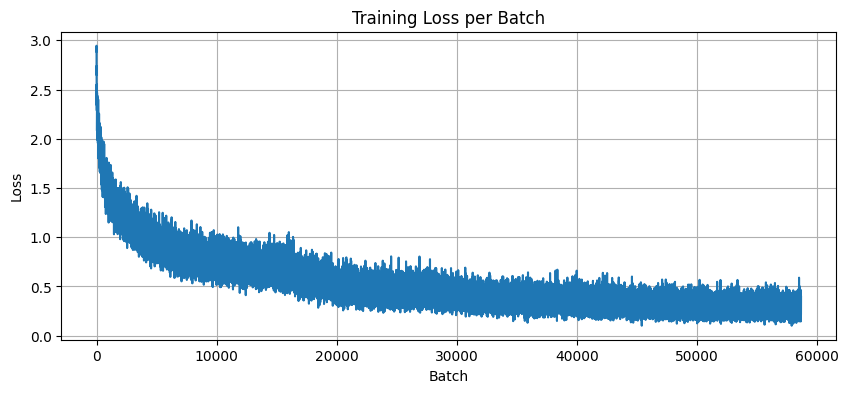

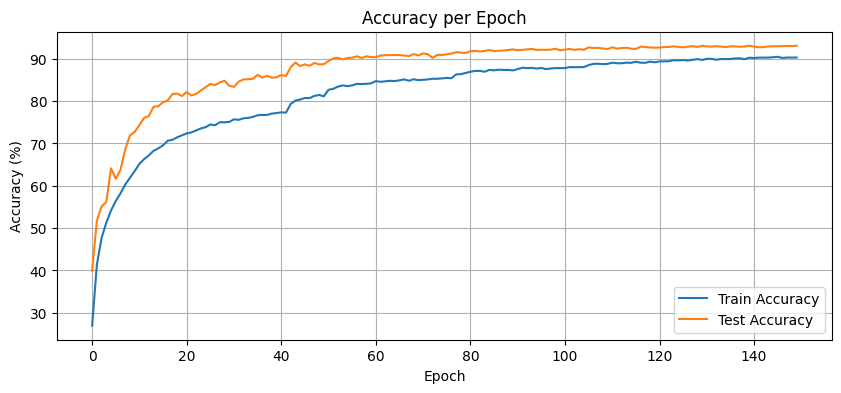

In [ ]:
def main():
    # Create model
    print("Creating model...")
    model = CIFAR10Network().to(device)
    print(model)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        verbose=True
    )

    # Train model
    model, batch_losses, train_accuracies, test_accuracies = train_model(
        model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device
    )

    # Print final accuracy
    print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")

    # Save model
    torch.save(model.state_dict(), 'cifar10_model.pth')
    print("Model saved to 'cifar10_model.pth'")

    # Plot results
    # Plot batch losses
    plt.figure(figsize=(10, 4))
    plt.plot(batch_losses)
    plt.title('Training Loss per Batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('batch_losses.png')
    plt.show()

    # Plot training and testing accuracies
    plt.figure(figsize=(10, 4))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracies.png')
    plt.show()

if __name__ == "__main__":
    main()